In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import Concatenate
# from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Figure out how partial derivatives and gradients work
# def f(x):
#     return tf.math.square(x[0]) + tf.math.square(x[1]) + tf.math.multiply(x[0],x[1]) # x^2+y^2+xy

# x_bar = tf.Variable([[1.0,2,3,4],[1,1,1,1]]) # x_bar = (x,y)
# print(x[0])
# with tf.GradientTape() as t:
#     t.watch(x_bar)
#     f = f(x_bar)
# grad_f = t.gradient(f,x_bar)
# df_dx = grad_f[0]
# df_dy = grad_f[1]
# print(grad_f, df_dx, df_dy)
# a = tf.constant([[1, 2, 3, 4],[1,2,3,4]])
# b = tf.constant([1, 1, 1, 1])
# d = tf.constant([2,2,2,2])
# c = tf.subtract(a,b)
# c = tf.stack([a,b,d])
# print(c)
# c = tf.squeeze(c)
# print(c)

In [4]:
# Construct model
model = Sequential()
model.add(Dense(100, input_shape=[2,], activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1))

In [27]:
def loss_fn(model, int_pts, theta_in, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])
    
# Find loss for interior points ###########################################################################
    with tf.GradientTape() as t:
        t.watch(int_pts)
        with tf.GradientTape() as tt:
            tt.watch(int_pts)
            g = model(int_pts)
#         print('g = ', g)
        grad_g = t.gradient(g, int_pts)
    laplace_g = tt.gradient(g, int_pts)
#     print('Hessian = ',tf.shape(hess_g))
    
#     print(grad_g)
#     dg_dx = grad_g[0:,0,0] # dg/dx
#     print(dg_dx)
#     dg_dy = grad_g[0:,0,1] # dg/dy

    laplace_g_l2_norm = tf.nn.l2_loss(laplace_g) #  MSE differential operator / 2
    
# Find loss for inner boundary points #####################################################################
    x_in = tf.math.scalar_mul(2, tf.math.cos(theta_in)) # x = 2cos(theta_in)
    y_in = tf.math.scalar_mul(2, tf.math.sin(theta_in)) # y = 2sin(theta_in)
    in_bnd_pts = tf.transpose(tf.stack([x_in,y_in],0))
    in_bnd_err = model(in_bnd_pts) # in_bnd_err = g(x,y)-0
    in_bnd_mse = tf.nn.l2_loss(in_bnd_err) # MSE inner bound points / 2
    
# Find loss for outer boundary points #####################################################################    
    x_out = tf.math.scalar_mul(4, tf.math.cos(theta_out)) # x = 4cos(theta_in)
    y_out = tf.math.scalar_mul(4, tf.math.sin(theta_out)) # y = 4sin(theta_in)
    out_bnd_pts = tf.transpose(tf.stack([x_out,y_out],0))
    out_bnd_err = tf.math.subtract(model(out_bnd_pts), # out_bnd_err = g(x,y)-4sin(5theta)
                                   tf.math.scalar_mul(4, tf.math.sin(tf.math.scalar_mul(5, theta_out))))
    out_bnd_mse = tf.nn.l2_loss(out_bnd_err) # MSE outer bound points / 2

# Find total boundary loss ######################################################################
    bnd_loss = tf.math.add(in_bnd_mse, out_bnd_mse)

# Total loss ##############################################################################################
    loss = tf.math.add(laplace_g_l2_norm, bnd_loss)
    
    return loss

In [33]:
# Train network
def train_for():

# Define training parameters ##############################################################################    
    optimizer = tf.keras.optimizers.Adam() # Fancy gradient decent
    epochs = 20
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    int_pts_size = 1000 # Number of interior points to sample each iteration
    theta_in_size = 1000 # Number of inner boundary points to sample each iteration
    theta_out_size = 1000 # Number of outer boundary points to sample each iteration


    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
# Sample interior points ##################################################################################
            r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
                tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1,int_pts_size], minval=0, maxval=1))))
            theta_int = tf.random.uniform([1,int_pts_size], minval=0, maxval=2*np.pi)
            
            # Convert to cartestian
            x_int = tf.math.multiply(r_int, tf.math.cos(theta_int)) 
            y_int = tf.math.multiply(r_int, tf.math.sin(theta_int))
            int_pts = tf.transpose(tf.stack([x_int, y_int], 0))
            
# Sample inner bound thetas ###############################################################################    
            theta_in = tf.random.uniform([1,theta_in_size], minval=0, maxval=2*np.pi)
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                loss = loss_fn(model, int_pts, theta_in, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 5 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [34]:
train_for()

Epoch 000: Loss: 4013313.000
Epoch 005: Loss: 3991642.000
Epoch 010: Loss: 3996786.250
Epoch 015: Loss: 4006516.750


In [35]:
# Generate test points to plot ############################################################################
in_bnd_pts_size = 1000 # Number of inner boundary points to sample 
out_bnd_pts_size = 1000 # Number of outer boundary points to sample 
int_pts_size = 1000 # Number of interior points to sample

# Sample interior points ##################################################################################
r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
    tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1, int_pts_size], minval = 0, maxval=1))))
theta_int = tf.random.uniform([1, int_pts_size], minval=0, maxval=2*np.pi)
# Convert to cartestian
x_int = tf.math.multiply(r_int, tf.math.cos(theta_int)) 
y_int = tf.math.multiply(r_int, tf.math.sin(theta_int))
int_pts = tf.stack([x_int, y_int], 0)

# Sample inner boundary points ############################################################################
theta_in = tf.random.uniform([1, in_bnd_pts_size], minval=0, maxval=2*np.pi)
x_in = tf.math.scalar_mul(2, tf.math.cos(theta_in))
y_in = tf.math.scalar_mul(2, tf.math.sin(theta_in))
in_bnd_pts = tf.stack([x_in, y_in], 0)

# Sample outer boundary points ############################################################################
theta_out = tf.random.uniform([1, out_bnd_pts_size], minval=0, maxval=2*np.pi)
x_out = tf.math.scalar_mul(4, tf.math.cos(theta_out))
y_out = tf.math.scalar_mul(4, tf.math.sin(theta_out))
out_bnd_pts = tf.stack([x_out, y_out], 0)
# print(out_bnd_pts.shape)
# print(out_bnd_pts)

test_pts = tf.transpose(tf.concat([int_pts, in_bnd_pts, out_bnd_pts],2))
# print(test_pts)
print(test_pts.shape)

z = model(test_pts)
print(tf.shape(z))

(3000, 1, 2)
tf.Tensor([3000    1    1], shape=(3,), dtype=int32)


(3000,)
(3000,)
(3000,)


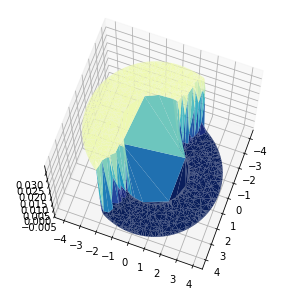

In [43]:
# Plot ####################################################################################################
fig = pylab.figure(figsize=plt.figaspect(1))
ax = Axes3D(fig)

X = test_pts[0:, 0, 0].numpy()
print(X.shape)
Y = test_pts[0:, 0, 1].numpy()
print(Y.shape)
Z = z[0:, 0, 0].numpy()
print(Z.shape)

ax.plot_trisurf(X,Y,Z, cmap=plt.cm.YlGnBu_r)
ax.view_init(70, 20)
plt.show()

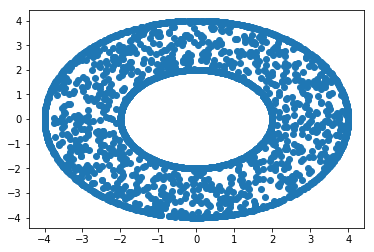

In [44]:
plt.scatter(X,Y)
plt.show()